In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as spa
import scipy.linalg as la
from zipfile import ZipFile
import matplotlib.pyplot as plt
import time
from urllib.request import urlretrieve
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
# from memory_profiler import profile
# %load_ext memory_profiler

In [2]:
def download_data(url):
  """
    Download data from url
  """
  filename = os.path.basename(url)
  if not os.path.exists(filename):
    path, _ = urlretrieve(url, filename)
    print("Data downloaded successfuly !")
  else:
    print("Data already downloaded")

download_data('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')

Data already downloaded


In [3]:
def extract_data(filename, extract_to_path):
  """
    Extract data into project director
  """
  file_dir = os.path.join(extract_to_path, os.path.basename(filename).split('.')[0])
  # extract file into the project directory
  if not os.path.exists(file_dir)and os.path.exists(filename):
    with ZipFile(filename, 'r') as zf:
      zf.extractall(path=extract_to_path)
      print(f"Extracted to {file_dir} directory")
  else:
    print("Data already extracted")

extract_data("ml-latest-small.zip", './data')

Data already extracted


**Date Load and EDA**

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


In [4]:
# load data of movies and ratings
data_dir = "./data/ml-latest-small"
movies_df = pd.read_csv(os.path.join(data_dir, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(data_dir, "ratings.csv"))

In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# sort the ratings based on userId and movieId for later use
ratings_df.sort_values(by=['userId', 'movieId']).reset_index(drop=True, inplace=True)
#remove timestamp since not useful for this task
ratings_df.drop(columns=['timestamp'], inplace=True)

In [8]:
#total number of records
print(f"#ratings: {ratings_df.shape[0]}")
print(f"#movies: {movies_df.shape[0]}")

#ratings: 100836
#movies: 9742


In [9]:
#merege the two dataframes with the movieId(common column)
movie_ratings_df = pd.merge(ratings_df, movies_df, on="movieId")

In [10]:
#check null values
print(f"# null values:\n{movie_ratings_df.isna().sum()}\n")

#check if there is duplicated movies
print(f"duplicated movies: {movies_df['movieId'].duplicated().sum()}")

# null values:
userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

duplicated movies: 0


In [11]:
#number of unique users and movies
print(f"# unique users: {movie_ratings_df['userId'].nunique()}")
print(f"# unique movies: {movies_df['movieId'].nunique()}")
print(f"# unique movies with rating: {movie_ratings_df['movieId'].nunique()}")
print(f"# movies not rated: {movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())].shape[0]}")

# unique users: 610
# unique movies: 9742
# unique movies with rating: 9724
# movies not rated: 18


In [12]:
unrated_movies = movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())]
print(f"# unrated movies: {unrated_movies.shape[0]}")
unrated_movies.head()

# unrated movies: 18


,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War


In [13]:
#most of the movies are 3 and above rated
most_rated_movie_count = movie_ratings_df['rating'].value_counts().sort_values(ascending=False)[movie_ratings_df['rating']\
.value_counts().keys() >= 3.0].sum()
print(f"# most rated movies(i.e rating >= 3.0) : {most_rated_movie_count}")

# most rated movies(i.e rating >= 3.0) : 81763


In [14]:
# top 5 mean rating for movies
movies_grouped_by_title = movie_ratings_df.groupby('title', sort=False)['rating']
movies_grouped_by_title.mean().sort_values(ascending=False).head()

title
Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981)    5.0
Tokyo Tribe (2014)                                                    5.0
Colourful (Karafuru) (2010)                                           5.0
7 Faces of Dr. Lao (1964)                                             5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)                           5.0
Name: rating, dtype: float64

In [15]:
# highly rated movies
rating_count = movies_grouped_by_title.count().sort_values(ascending=False)
rating_count.head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [16]:
#each user rated a minimum and a maximum of 20 movies and 2698 movies respectively
user_rating_count = movie_ratings_df.groupby("userId", sort=False)['title'].count().sort_values(ascending=False)
print(f"min # of movies were rated by a user: {user_rating_count.min()}")
print(f"max # of movies were rated by a user: {user_rating_count.max()}")

min # of movies were rated by a user: 20
max # of movies were rated by a user: 2698


In [17]:
#movies with more tha 20 ratings
rating_count[rating_count >= 20]

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Meet Joe Black (1998)                20
Gone Baby Gone (2007)                20
Behind Enemy Lines (2001)            20
Solaris (2002)                       20
Real Genius (1985)                   20
Name: rating, Length: 1297, dtype: int64

In [18]:
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


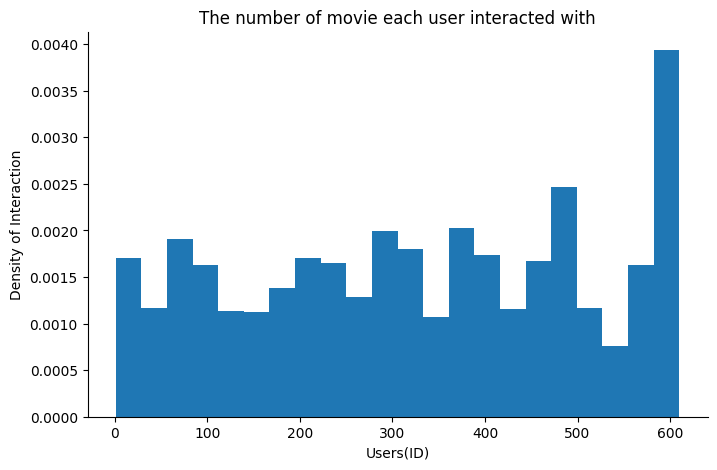

In [19]:
# The plot indicate some users rate many movies
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['userId'], bins=22, density=True)
plt.xlabel('Users(ID)')
plt.ylabel('Density of Interaction')
plt.title(f'The number of movie each user interacted with')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

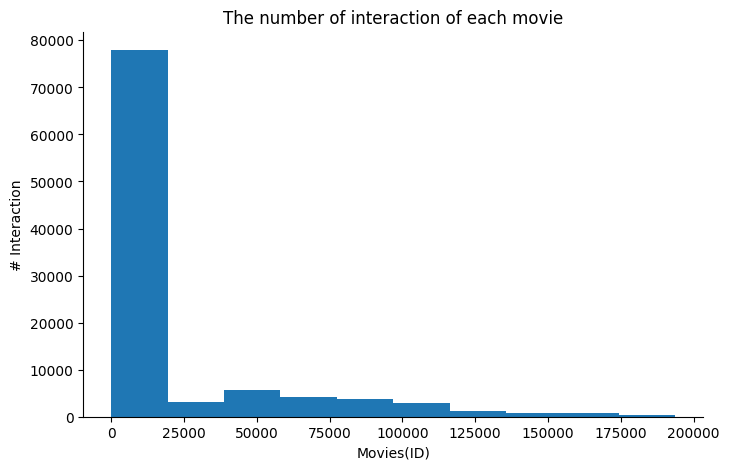

In [20]:
# This is the equivalent of the previous; some movies have been rated by many users
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['movieId'])
plt.xlabel('Movies(ID)')
plt.ylabel('# Interaction')
plt.title(f'The number of interaction of each movie')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

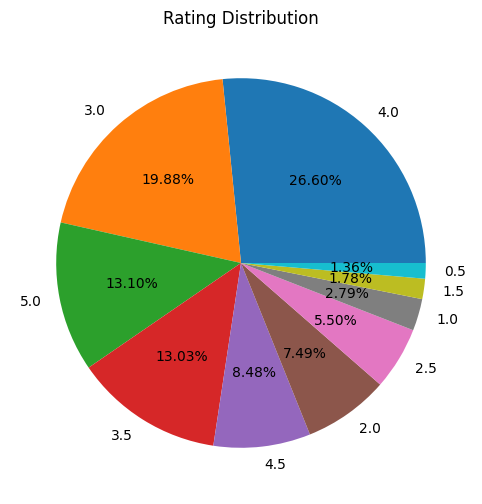

In [21]:
# This plot shows that the majority of the ratings are 4 and the minority is 0.5
plt.figure(figsize=(8, 6))
plt.pie(ratings_df['rating'].value_counts(), labels=ratings_df['rating'].value_counts().index, autopct="%1.2f%%")
plt.title('Rating Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

**Algorithm: The Iterative BiRank Algorithm**



**Input:** Weight matrix \( W \), query vectors \( p<sub>0</sub> \), \(u<sub>0</sub>), and hyper-parameters \(&alpha;, &beta; \)  
**Output:** Ranking vectors \( **p**, **u** \)  

1.  Symmetrically normalize \( W \):
  \[
   S = D<sub>u</sub><sup>-1/2</sup> W D<sub>p</sub><sup>-1/2</sup>
   \]
2.   Randomly initialize \( **p** \) and \( **u** \)
3. **while** Stopping criteria is not met **do**  
   \[
   p &larr; &alpha; S<sup>T</sup> u + (1 - &alpha;) p<sub>0</sub>
   \];  
   \[
   u &larr; &beta; S p + (1 - &beta;) u<sup>0</sup>
   \];
4. **end**
5. **return** \( ***p*** \) and \( ***u*** \)


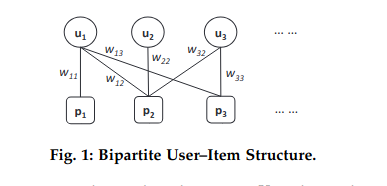

Reference:

He, X., Gao, M., Kan, M.-Y., & Wang, D. (2017). BiRank: Towards Ranking on Bipartite Graphs (No. arXiv:1708.04396). arXiv. https://doi.org/10.48550/arXiv.1708.04396


In [22]:
def birank(W, U0, P0, alpha=0.85, beta=0.85, max_iter=100, tol=1e-6, verbose=False):
    """
    A BiRank algorithm implementation for bipartite graph ranking.

    Args:
      W (coo_matrix) : Weight matrix for users and items (n_users x n_items).
      U0 (dia_matrix): Query matrix for users (n_users x n_users).
      P0 (coo_matrix): Query matrix for items (n_users x n_items).
      alpha, beta: hyper-parameters (Damping factors)
      max_iter: Maximum number of iterations
      tol: Tolerance for convergence
      verbose: If True, print the iteration information

    Returns:
      U (csr_matrix): Ranking matrix of users (n_users x n_users).
      P (csr_matrix): Ranking matrix of items for each user (n_users x n_items).
    """
    # convert Weight matrix into float type (ratings)
    W = W.astype('float', copy=False)

    # Compute the row-sum and col-sum of weight maxtrix
    du = W.sum(axis=1).A1
    dp = W.sum(axis=0).A1

    # avoid division by zero
    du[np.where(du == 0)] += 1e-10
    dp[np.where(dp == 0)] += 1e-10

    # inverse square root of the row-sum and col-sum and form diagonal matrix
    du_inv_sqrt = spa.diags(1 / np.sqrt(du))
    dp_inv_sqrt = spa.diags(1 / np.sqrt(dp))

    #Symmetrically normalized weight matrix and convert it into csr for efficient matrix multiplication for update rule
    S = du_inv_sqrt.dot(W).dot(dp_inv_sqrt)
    S = S.tocsr()
    St = S.T

    #initalize the user and item as query matrices
    U_last = U0.copy()
    P_last = P0.copy()

    for itr in range(max_iter):
        # update rules for items and users
        P = alpha * (St.dot(U_last)).T + (1 - alpha) * P0
        U = beta * (S.dot(P_last.T)) + (1 - beta) * U0

        # compute the frobinus norm to get the errors from the previous
        p_error = la.norm((P - P_last).toarray(), ord="fro")
        u_error = la.norm((U - U_last).toarray(), ord="fro")

        if verbose:
            print(f"Iteration: {itr}, Item Rank Error: {p_error}, User Rank Error: {u_error}")

        if p_error < tol and u_error < tol:
            print(f"converges after {itr} iterations")
            break
        P_last = P
        U_last = U

    return U, P

In [23]:
def generate_birank(W, verbose=False):
  """
    generate birank

    Args:
      W: A sparse matrix of users and movies (n_users x num_items)
      U0: A sparse matrix of users and users (n_users x n_users)
      P0: A sparse matrix of user and items (n_users x num_items)

    Returns:
      U: A sparse matrix of users and users (n_users x n_users)
      P: A sparse matrix of users and items (n_users x num_items)
  """

  U0 = spa.eye(W.shape[0])
  P0 = W.copy().tocsr()
  return birank(W, U0, P0, verbose=verbose)

In [24]:
def generate_unique_index(data_df, user_col_name, item_col_name):
  """
    create unique index for users and movies

    Args:
      data_df: A pandas dataframe of users, movies, and ratings
      user_col_name: column name of the users
      item_col_name: column name of the movies

    Returns:
      data_df: A pandas dataframe of users, movies, and ratings with indexes of users and movies
  """

  user_idx = pd.DataFrame(data_df[user_col_name].unique(), columns=[user_col_name]).reset_index()
  user_idx = user_idx.rename(columns={'index': 'user_index'})

  item_idx = pd.DataFrame(data_df[item_col_name].unique(), columns=[item_col_name]).reset_index()
  item_idx = item_idx.rename(columns={'index': 'item_index'})

  #merge the indexes of the users and items
  data_df = data_df.merge(user_idx, on=user_col_name)
  data_df = data_df.merge(item_idx, on=item_col_name)

  return data_df

In [25]:
def create_adj_matrix(data_df, user_index_col, item_index_col, weight_col_name):
  """
    create adjacency matrix

    Args:
      data_df: A pandas dataframe of users, movies, and ratings
      user_col_name: column name of the users
      item_col_name: column name of the movies
      weight_col_name: column name of the ratings

    Returns:
      Weight: A sparse matrix of users and movies
  """

  Weight = spa.coo_matrix((data_df[weight_col_name],
            (data_df[user_index_col].values, data_df[item_index_col].values))
   )

  return Weight

In [ ]:
#set user, item, weight col names
user_col = 'userId'
item_col = 'movieId'
weight_col = 'rating'

#set user and item index col names
item_index_col = 'item_index'
user_index_col = 'user_index'

# split the data into train and test
train_df, test_df = train_test_split(movie_ratings_df, test_size=0.2, random_state=42)

# generate unique indexes for users and movies(items)
movie_ratings_df = generate_unique_index(train_df, user_col, item_col)
W = create_adj_matrix(train_df, user_index_col, item_index_col, weight_col)

# Generate BiRank scores
U, P = generate_birank(W, verbose=True)

Iteration: 0, Item Rank Error: 878.1547095869569, User Rank Error: 419.9633393763384
Iteration: 1, Item Rank Error: 304.80502343140205, User Rank Error: 362.1882851764847
Iteration: 2, Item Rank Error: 259.7298415732528, User Rank Error: 248.29861199817537
Iteration: 3, Item Rank Error: 208.16198067568456, User Rank Error: 211.16974957103164
Iteration: 4, Item Rank Error: 176.96689572013736, User Rank Error: 176.00653366475507
Iteration: 5, Item Rank Error: 149.26907455275096, User Rank Error: 149.61484371058805
Iteration: 6, Item Rank Error: 126.88213027312905, User Rank Error: 126.74779964327382
Iteration: 7, Item Rank Error: 107.68208341421081, User Rank Error: 107.73700514389195
Iteration: 8, Item Rank Error: 91.5303575364734, User Rank Error: 91.50706391926343
Iteration: 9, Item Rank Error: 77.77110419827872, User Rank Error: 77.78126442823498
Iteration: 10, Item Rank Error: 66.1055570797942, User Rank Error: 66.10102440929118
Iteration: 11, Item Rank Error: 56.18386551959096, Use

In [29]:
U.shape, P.shape

((610, 610), (610, 9724))

In [ ]:
def generate_recommendation(df, U_last, P_last):
    n_users = U_last.shape[0]
    for i in range(n_users):
        
    